In [4]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import tritonclient.grpc as grpcclient
from tqdm.auto import tqdm
from dotenv import load_dotenv
import random
import ipyplot

from utils import *

load_dotenv()

True

In [5]:
with open(JSON_DATA_FILE) as f:
    facedetect_data = json.load(f)

In [6]:
triton_client = grpcclient.InferenceServerClient(url=TRITON_SERVER_URL, verbose=False)

model_metadata = triton_client.get_model_metadata(
    model_name=FPENET_MODEL_NAME, model_version=MODEL_VERSION
)

model_config = triton_client.get_model_config(
    model_name=FPENET_MODEL_NAME, model_version=MODEL_VERSION
).config

input_names = [i.name for i in model_config.input]
output_names = [i.name for i in model_config.output]

In [7]:
def render_fpenet_image(clip, points):
    img = Image.fromarray(clip.reshape((80, 80)).astype("uint8"), "L").convert("RGB")
    draw = ImageDraw.Draw(img)
    for x, y in points:
        draw.point((x, y), fill="#76b900")
    return img

/opt/conda/lib/python3.8/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



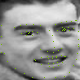
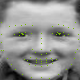
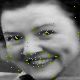
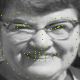
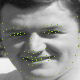
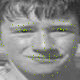
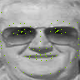
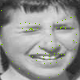


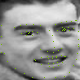
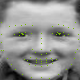
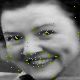
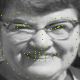
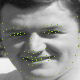
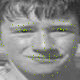
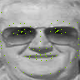
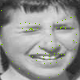

In [8]:
n = 0
max_images = 8
show_me_grid = []
results = []
for json_items in facedetect_data:
    if (json_items["faces"][0]["probability"] != 0) and (n <= max_images):
        try:
            results.append(
                submit_to_fpenet(
                    json_items,
                    input_names[0],
                    output_names,
                    request_id=json_items["filename"],
                    timeit=False,
                    return_clips=True,
                )
            )
            n += 1
        except Exception as e:
            print("There was an exception: {}".format(e))


for responses, clips in results:
    for response, clip in zip(responses, clips):
        points = response.squeeze()
        img = render_fpenet_image(clip, points)
        show_me_grid.append(img)

ipyplot.plot_images(
    images=show_me_grid, img_width=160, show_url=False, max_images=max_images
)

In [28]:
response, clip = results[5]

In [30]:
import numpy as np
from algorithm import *


In [ ]:
# DEBUG
# facedetect_data = random.sample(facedetect_data, N_DEBUG)

In [ ]:
pbar = tqdm(
    total=len(facedetect_data),
    desc="Submitting photos to {} at {}".format(FPENET_MODEL_NAME, TRITON_SERVER_URL),
)

results = []

with ThreadPoolExecutor() as executor:
    for chunk in chunked(facedetect_data, THREAD_CHUNKS):
        futures = []
        for json_items in chunk:
            pbar.update()
            if json_items["faces"][0]["probability"] != 0:
                futures.append(
                    executor.submit(
                        submit_to_fpenet,
                        json_items,
                        input_names[0],
                        output_names,
                        request_id=json_items["filename"],
                    )
                )

        for future in as_completed(futures):
            try:
                infer_result = future.result()
                results.append(infer_result)
            except Exception as e:
                print("There was an exception: {}.".format(e))

___